In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
import keras.backend as K
import scipy

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
name = 'fashion_DUALGAN'
if not os.path.exists("saved_model/"+name):
        os.mkdir("saved_model/"+name)
if not os.path.exists("images/"+name):
        os.mkdir("images/"+name)

In [3]:
# Download the dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('X_train', X_train.shape,'y_train', y_train.shape)
print('X_test', X_test.shape,'y_test', y_test.shape)

X_train (60000, 28, 28) y_train (60000,)
X_test (10000, 28, 28) y_test (10000,)


In [4]:
input_classes = pd.Series(y_train).nunique()
input_classes

10

In [5]:
# Training Labels are evenly distributed
Train_label_count = pd.Series(y_train).value_counts()
Train_label_count

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
# Test Labels are evenly distributed
Test_label_count = pd.Series(y_test).value_counts()
Test_label_count

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
#label dictionary from documentation
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [8]:
X_train[1].shape

(28, 28)

In [9]:
#input dimensions
input_rows = X_train[1][0]
input_cols = X_train[1][1]
input_channels = 1

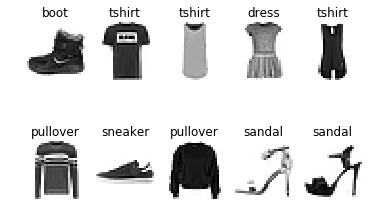

In [10]:
# plot images from the train dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')
    a.set_title(label_dict[y_train[i]])

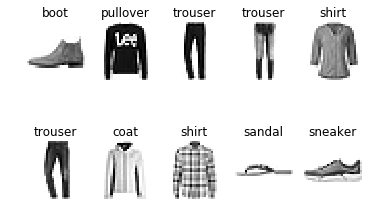

In [11]:
# plot images from the test dataset
for i in range(10):
    # define subplot
    a=plt.subplot(2, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_test[i], cmap='gray_r')
    a.set_title(label_dict[y_test[i]])

In [12]:
class DUALGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_dim = self.img_rows*self.img_cols

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.D_A = self.build_discriminator()
        self.D_A.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])
        self.D_B = self.build_discriminator()
        self.D_B.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.G_AB = self.build_generator()
        self.G_BA = self.build_generator()

        # For the combined model we will only train the generators
        self.D_A.trainable = False
        self.D_B.trainable = False

        # The generator takes images from their respective domains as inputs
        imgs_A = Input(shape=(self.img_dim,))
        imgs_B = Input(shape=(self.img_dim,))

        # Generators translates the images to the opposite domain
        fake_B = self.G_AB(imgs_A)
        fake_A = self.G_BA(imgs_B)

        # The discriminators determines validity of translated images
        valid_A = self.D_A(fake_A)
        valid_B = self.D_B(fake_B)

        # Generators translate the images back to their original domain
        recov_A = self.G_BA(fake_B)
        recov_B = self.G_AB(fake_A)

        # The combined model  (stacked generators and discriminators)
        self.combined = Model(inputs=[imgs_A, imgs_B], outputs=[valid_A, valid_B, recov_A, recov_B])
        self.combined.compile(loss=[self.wasserstein_loss, self.wasserstein_loss, 'mae', 'mae'],
                            optimizer=optimizer,
                            loss_weights=[1, 1, 100, 100])

    def build_generator(self):

        X = Input(shape=(self.img_dim,))

        model = Sequential()
        model.add(Dense(256, input_dim=self.img_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.4))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dropout(0.4))
        model.add(Dense(self.img_dim, activation='tanh'))

        X_translated = model(X)

        return Model(X, X_translated)

    def build_discriminator(self):

        img = Input(shape=(self.img_dim,))

        model = Sequential()
        model.add(Dense(512, input_dim=self.img_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1))

        validity = model(img)

        return Model(img, validity)

    def sample_generator_input(self, X, batch_size):
        # Sample random batch of images from X
        idx = np.random.randint(0, X.shape[0], batch_size)
        return X[idx]

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        # Domain A and B (rotated)
        X_A = X_train[:int(X_train.shape[0]/2)]
        X_B = scipy.ndimage.interpolation.rotate(X_train[int(X_train.shape[0]/2):], 90, axes=(1, 2))

        X_A = X_A.reshape(X_A.shape[0], self.img_dim)
        X_B = X_B.reshape(X_B.shape[0], self.img_dim)

        clip_value = 0.01
        n_critic = 4

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            # Train the discriminator for n_critic iterations
            for _ in range(n_critic):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Sample generator inputs
                imgs_A = self.sample_generator_input(X_A, batch_size)
                imgs_B = self.sample_generator_input(X_B, batch_size)

                # Translate images to their opposite domain
                fake_B = self.G_AB.predict(imgs_A)
                fake_A = self.G_BA.predict(imgs_B)

                # Train the discriminators
                D_A_loss_real = self.D_A.train_on_batch(imgs_A, valid)
                D_A_loss_fake = self.D_A.train_on_batch(fake_A, fake)

                D_B_loss_real = self.D_B.train_on_batch(imgs_B, valid)
                D_B_loss_fake = self.D_B.train_on_batch(fake_B, fake)

                D_A_loss = 0.5 * np.add(D_A_loss_real, D_A_loss_fake)
                D_B_loss = 0.5 * np.add(D_B_loss_real, D_B_loss_fake)

                # Clip discriminator weights
                for d in [self.D_A, self.D_B]:
                    for l in d.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                        l.set_weights(weights)

            # ------------------
            #  Train Generators
            # ------------------

            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B])

            # Plot the progress
#             print ("%d [D1 loss: %f] [D2 loss: %f] [G loss: %f]" \
#                 % (epoch, D_A_loss[0], D_B_loss[0], g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.save_imgs(epoch, X_A, X_B)
                self.save_model()
                print ("%d [D1 loss: %f] [D2 loss: %f] [G loss: %f]" \
                % (epoch, D_A_loss[0], D_B_loss[0], g_loss[0]))

    def save_imgs(self, epoch, X_A, X_B):
        r, c = 4, 4

        # Sample generator inputs
        imgs_A = self.sample_generator_input(X_A, c)
        imgs_B = self.sample_generator_input(X_B, c)

        # Images translated to their opposite domain
        fake_B = self.G_AB.predict(imgs_A)
        fake_A = self.G_BA.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_A, fake_B, imgs_B, fake_A])
        gen_imgs = gen_imgs.reshape((r, c, self.img_rows, self.img_cols, 1))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[i, j, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/"+name+"/_%d.png" % epoch)
        plt.imread("images/"+name+"/_%d.png" % epoch)
        plt.show()
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/"+name+"/%s.json" % model_name
            weights_path = "saved_model/"+name+"/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.G_AB, "dualgan_generator_G_AB")
        save(self.G_BA, "dualgan_generator_G_BA")
        save(self.D_A, "dualgan_discriminator_D_A")
        save(self.D_B, "dualgan_discriminator_D_A")
        save(self.combined, "dualgan_combined")

C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


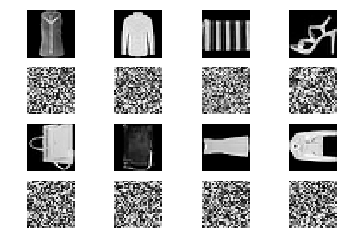

0 [D1 loss: 0.000082] [D2 loss: 0.000087] [G loss: 176.259674]


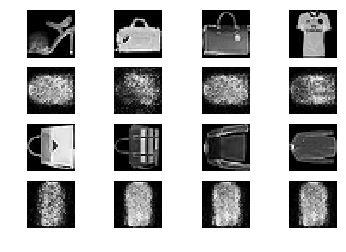

100 [D1 loss: 0.000041] [D2 loss: 0.000041] [G loss: 85.647156]


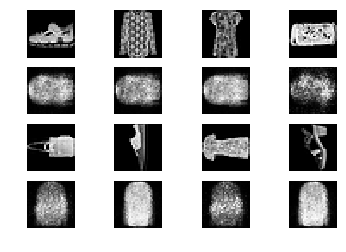

200 [D1 loss: 0.000037] [D2 loss: 0.000037] [G loss: 68.822571]


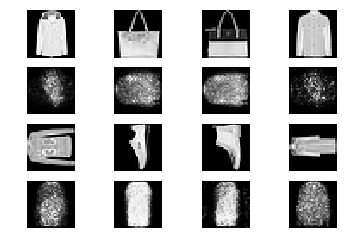

300 [D1 loss: 0.000035] [D2 loss: 0.000035] [G loss: 72.699936]


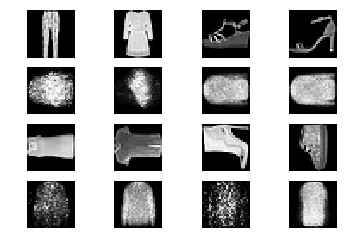

400 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 62.355850]


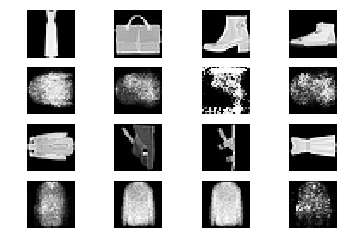

500 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 62.775192]


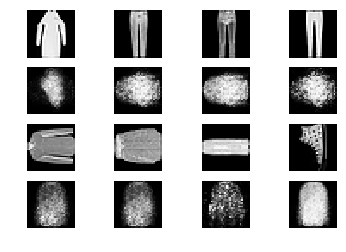

600 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 61.693535]


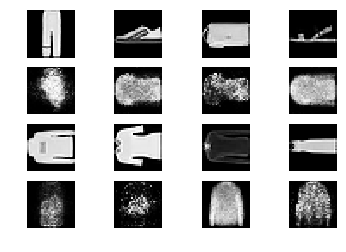

700 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 55.861778]


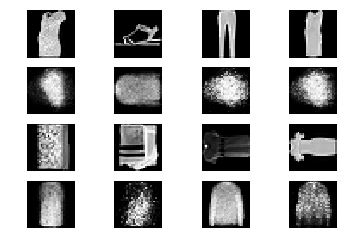

800 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 57.529236]


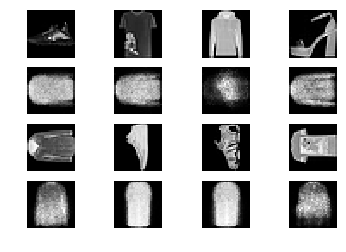

900 [D1 loss: 0.000034] [D2 loss: 0.000034] [G loss: 55.659302]


In [13]:
gan = DUALGAN()
gan.train(epochs=1000, batch_size=32, sample_interval=100)